# Hash et distribution

Une [fonction de hash](https://en.wikipedia.org/wiki/Hash_function) a pour propriété statistiques de transformer une distribution quelconque en distribution uniforme. C'est pour cela que beaucoup d'algorithmes utilisent ce type de fonction avant tout traitement pour répartir les données de manières uniformes plutôt que d'utiliser une variable une colonne telle quelle.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

## Récupérer un fichier wikipédia

In [6]:
from mlstatpy.data.wikipedia import download_pageviews
import os
from datetime import datetime

download_pageviews(datetime(2018, 2, 1), folder=".")

'./pageviews-20180201-000000.gz'

On ne garde que les pages françaises.

In [7]:
with open("pageviews-20180201-000000", "r", encoding="utf-8") as f:
    fr = filter(lambda line: line.startswith("fr "), f)
    with open("pageviews-20180201-000000.fr.txt", "w", encoding="utf-8") as g:
        for line in fr:
            g.write(line)

In [8]:
import pandas

df = pandas.read_csv(
    "pageviews-20180201-000000.fr.txt", encoding="utf-8", sep=" ", header=None
)
df.columns = "country page impressions _".split()
df = df[["page", "impressions"]]
df = df.sort_values("impressions", ascending=False)
print(df.shape)
df.head()

(136440, 2)


,page,impressions
131064,Wikipédia:Accueil_principal,10868
115817,Sp?cial:Search,8031
116771,Spécial:Recherche,2815
95020,Patrick_Dils,841
44847,France,668


Les données sont biaisées car les pages non démandées par les utilisateurs sur cett date ne sont pas répertoriées mais cela ne nuit pas à la démonstration faite ci-dessous.

## Distribution volume, impressions par rapprt au premier caractère

In [9]:
df["ch1"] = df["page"].apply(lambda r: r[0] if isinstance(r, str) else r)
df.head()

,page,impressions,ch1
131064,Wikipédia:Accueil_principal,10868,W
115817,Sp?cial:Search,8031,S
116771,Spécial:Recherche,2815,S
95020,Patrick_Dils,841,P
44847,France,668,F


In [10]:
co = df.copy()
co["volume"] = 1
gr = co.groupby("ch1", as_index=False).sum().sort_values("ch1")
gr.head()

,ch1,page,impressions,volume
0,$,$,2,1
1,&,&_(album),1,1
2,','Ndrangheta'Alî_Sharî'atî'Mamohato'Îmran,8,4
3,(,(3753)_Cruithne(What's_the_Story)_Morning_Glor...,60,54
4,-,--17-16-92-93-305-18-19-20-241-304,249,11


<Axes: xlabel='ch1'>

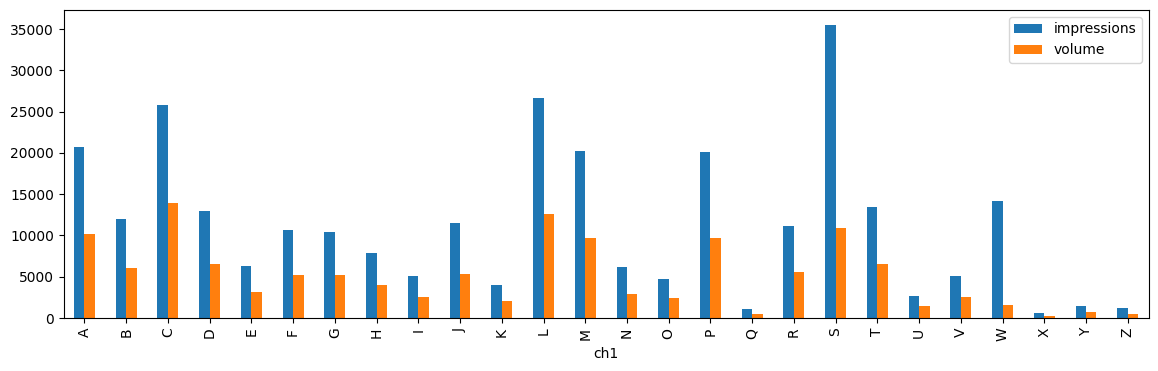

In [11]:
gr[(gr["ch1"] >= "A") & (gr["ch1"] <= "Z")].plot(
    x="ch1", y=["impressions", "volume"], kind="bar", figsize=(14, 4)
)

Il est possible de distribuer les impressions et les volumns sur plusieurs machines mais ce serait beaucoup plus simple si les volumes (volume de données) et les impressions (usage de ces données) suivent des distributions identiques.

## Distribution après hashage

In [12]:
import hashlib


def hash(text):
    md5 = hashlib.md5()
    md5.update(text.encode("utf-8"))
    return md5.hexdigest()


hash("France")

'0309a6c666a7a803fdb9db95de71cf01'

In [13]:
ha = co.copy()
ha["hash"] = ha["page"].apply(lambda r: hash(r) if isinstance(r, str) else r)
ha.head()

,page,impressions,ch1,volume,hash
131064,Wikipédia:Accueil_principal,10868,W,1,6cc68aa5234cb8c4e129d5b431eea95a
115817,Sp?cial:Search,8031,S,1,e4c619292a0e11c8afba20eb4531cbf8
116771,Spécial:Recherche,2815,S,1,6f86a30966129c5bf50147eb44c4e82c
95020,Patrick_Dils,841,P,1,624f2274ebdbb30187e57d430c58990d
44847,France,668,F,1,0309a6c666a7a803fdb9db95de71cf01


In [14]:
ha["ch2"] = ha["hash"].apply(lambda r: r[0] if isinstance(r, str) else r)
ha.head()

,page,impressions,ch1,volume,hash,ch2
131064,Wikipédia:Accueil_principal,10868,W,1,6cc68aa5234cb8c4e129d5b431eea95a,6
115817,Sp?cial:Search,8031,S,1,e4c619292a0e11c8afba20eb4531cbf8,e
116771,Spécial:Recherche,2815,S,1,6f86a30966129c5bf50147eb44c4e82c,6
95020,Patrick_Dils,841,P,1,624f2274ebdbb30187e57d430c58990d,6
44847,France,668,F,1,0309a6c666a7a803fdb9db95de71cf01,0


In [15]:
gr = ha.groupby("ch2", as_index=False).sum().sort_values("ch2")
gr.head()

,ch2,page,impressions,ch1,volume,hash
0,0,FranceSpécial:JournalLua_BlancoGitListe_des_ép...,18493,FSLGLLDLÎAÉJNDSÉSSCBBCJGASM1LAATSARAALDZJSMCML...,8531,0309a6c666a7a803fdb9db95de71cf010bc97f0b21a608...
1,1,Élisabeth_RevolGrand_ReimsÉdouard_LockroyNora_...,16615,ÉGÉNCTNNNSMSALJTRFLAPLVMWSCFDJJVCTBLHNLJLRDDFT...,8513,14edb218946d67eb425e08231e3c25b51f01421c8827b1...
2,2,Australie-OccidentaleRoger_FedererSpécial:List...,17276,ARSSSESNLYBP4NIAPAÉADNDLCPJLSCSNESLFSLNUSJSJPS...,8514,2350f0145112af1d3b70bdfe583dbfb6203b3bdfe59c7a...
3,3,Daniel_Balavoine-1er_févrierSid_ViciousLune_ro...,17219,D-1SLDSCACLCETFLBMBLBASSZDJHDDONCDTSASMQPABJBG...,8547,3f922364907f960c529c4a65ac44372e336d5ebc543653...
4,4,Rasual_ButlerPetra_(cygne)Mehdi_Carcela-Gonzal...,16847,RPMCTFTSEGPHDSACCCCBDLRHMHREPSMLRLLSISMLMPRNTS...,8468,4b85266e177e3327174b900be1d8147c4a2130906289ef...


<Axes: xlabel='ch2'>

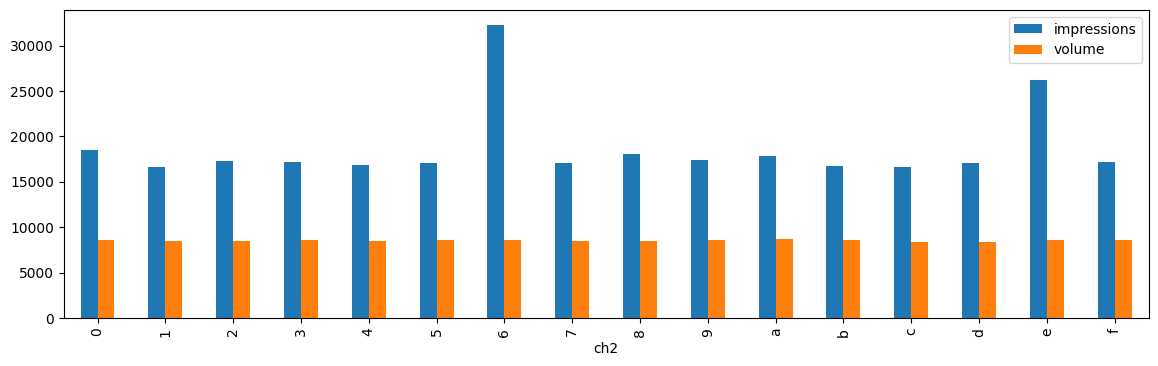

In [16]:
gr.plot(x="ch2", y=["impressions", "volume"], kind="bar", figsize=(14, 4))

Après avoir appliqué une fonction de hashage, les deux distributions volumes et impressions sont presque uniforme par rapport au premier caractère du hash. Il reste un pic : il provient de la page wikipédia la plus demandée. Ces pages très demandées sont très souvent en très petit nombre et on implémentera une mécanisme de cache s'il s'agit d'un site web. En revanche, lors d'un calcul distribué sur Map / Reduce, un des problèmes consistera à traiter ces clés de distributions qui regroupent une part trop importante des données.

On recommence le même raisonnement en utilisant les deux premiers caractères du hash comme clé de distribution.

<Axes: xlabel='ch12'>

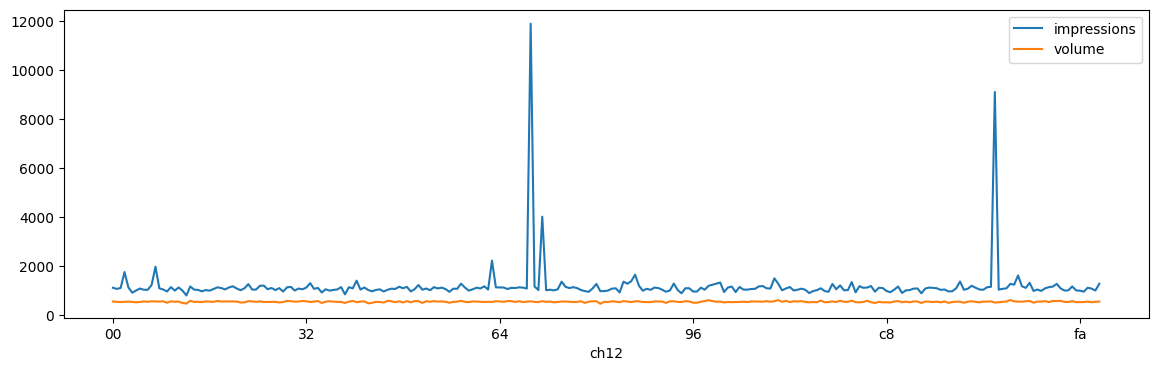

In [17]:
def substr(s, size=2):
    if isinstance(s, str):
        if len(s) < size:
            return s
        return s[:size]
    return s


ha = ha.copy()
ha["ch12"] = ha["hash"].apply(substr)
gr = ha.groupby("ch12", as_index=False).sum().sort_values("ch12")
gr.plot(x="ch12", y=["impressions", "volume"], figsize=(14, 4))

Dans ce cas précis, si le traitement appliqué aux données est d'un coût proportionnelle à la taille des données associées à chaque clé, cela signifie qu'une opération de type **reduce** aura un temps de traitement proportionnel au volume de données associée à la plus grande clé et non au nombre de machines puisque toutes les données d'une même clé sont envoyées sur la même machine.